In [2]:
#load common utilities
import os
from datetime import datetime
import glob

#load data analysis packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import squarify
from pywaffle import Waffle


import folium  #needed for interactive map
from folium.plugins import HeatMap
import geopy
from geopy.distance import geodesic

#set display options
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

from IPython.display import HTML, IFrame

#set working directory
rootdir = os.getcwd()
data_path = "../data"

import sys

sys.path.append('../src/scripts/')

import sg

philly_center = [39.9526, -75.1652]

# Read in SafeGraph Data

In [31]:
pd.read_csv(f"{data_path}/processed/cbg_visits.csv")

,census_block_group,visits_wawa,visits_7_eleven,visits_starbucks
0,10010202001,4.0,NaN,NaN
1,10030108002,4.0,NaN,NaN
2,10030113004,4.0,NaN,NaN
3,10279589001,8.0,NaN,NaN
4,10439645003,6.0,NaN,NaN
...,...,...,...,...
13358,551110004011,NaN,NaN,4.0
13359,720252005007,NaN,NaN,4.0
13360,720252012002,NaN,NaN,4.0
13361,720959514005,NaN,NaN,5.0


# Selecting Census Variables

Variable descriptions are located in ```/data/raw/census/metadata/cbg_field_descriptions.csv```

[SafeGraph Blog](https://www.safegraph.com/blog/beginners-guide-to-census)

In [22]:
def read_census_data(variable_dict):
    dfs = []
    
    data_sets = sorted(list(set([x[0:3].lower() for x in variable_dict])))
    print("Data Sets: ", data_sets)
    
    for data_set in data_sets:
        dfs.append(pd.read_csv(f"{data_path}/raw/census/data/cbg_{data_set}.csv", dtype={'census_block_group': "object"},
                               usecols=["census_block_group"] + [x for x in list(variable_dict.keys()) if x[0:3].lower() == data_set])\
                   .set_index('census_block_group'))
    
    df = pd.concat(dfs, axis=1)
    df = df.rename(columns=variable_dict)
    
    return df.reset_index()

read_census_data({
    "B01001e1": "total_population",
    "B02001e2": "pop_white",
    "B02001e3": "pop_black",
    "B02001e5": "pop_asian",
    "B03002e1": "pop_hispanic"
})

Data Sets:  ['b01', 'b02', 'b03']


,census_block_group,total_population,pop_white,pop_black,pop_asian,pop_hispanic
0,010010201001,745,585,160,0,745
1,010010201002,1265,1083,104,9,1265
2,010010202001,960,361,568,0,960
3,010010202002,1236,615,571,24,1236
4,010010203001,2364,1481,515,27,2364
...,...,...,...,...,...,...
220328,721537506011,921,752,0,0,921
220329,721537506012,2703,2230,207,0,2703
220330,721537506013,1195,1085,25,0,1195
220331,721537506021,2005,1662,68,0,2005


In [26]:
def read_census_data2(var_dict):
    flatten = lambda t: [item for sublist in t for item in sublist]
    var_list = flatten(list(var_dict.values()))
    data_sets = sorted(list(set([x[0:3].lower() for x in var_list])))
    print("Data Sets: ", data_sets)
    
    dfs = []
    for data_set in data_sets:
        dfs.append(pd.read_csv(f"{data_path}/raw/census/data/cbg_{data_set}.csv", dtype={'census_block_group':"object"}, usecols=["census_block_group"] + [x for x in var_list if x[0:3].lower() == data_set])\
                  .set_index('census_block_group'))
    
    df = pd.concat(dfs, axis=1)
    for col in var_dict:
        df[col] = np.sum(df[var_dict[col]], axis=1)
    
    return df[list(var_dict.keys())]


age_dict = {
    "total_population": ["B01001e1"],
    "male_20_29": ["B01001e8", "B01001e9", "B01001e10","B01001e11"],
    "male_30_39": ["B01001e12","B01001e13"],
    'female_20_29': ["B01001e32", "B01001e33", "B01001e34","B01001e35"],
    'female_30_39': ["B01001e36", "B01001e37"]
}


read_census_data2(age_dict)

Data Sets:  ['b01']


,total_population,male_20_29,male_30_39,female_20_29,female_30_39
census_block_group,,,,,
010010201001,745,38,55,55,61
010010201002,1265,104,59,66,57
010010202001,960,84,43,29,57
010010202002,1236,130,107,76,55
010010203001,2364,122,196,177,200
...,...,...,...,...,...
721537506011,921,96,25,75,17
721537506012,2703,374,184,184,207
721537506013,1195,147,14,139,10


In [27]:
def calc_gender(brands):
    cbg_visits = pd.read_csv(f"{data_path}/processed/cbg_visits.csv", dtype={'census_block_group': "object"})

    pop_stats = read_census_data({
        "B01001e1": "total_population",
        "B01001e2": "total_population_male",
        "B01001e26": "total_population_female"
    })
    
    dfs = []
    for brand in brands:
        
        df = cbg_visits.set_index("census_block_group")[f"visits_{brand}"].to_frame().merge(pop_stats, on='census_block_group', how='left').fillna(0)
        df = df[df['total_population'] > 0]

        df['percent_male'] = df.apply(lambda x: x.total_population_male / x.total_population, axis=1)
        df['percent_female'] = df.apply(lambda x: x.total_population_female / x.total_population, axis=1)
        df['est_male'] = df[f"visits_{brand}"] * df['percent_male']
        df['est_female'] = df[f"visits_{brand}"] * df['percent_female']

        df = df[['est_male', 'est_female']].sum().to_frame().T
        df['brand'] = brand
        dfs.append(df)
    
    
    return pd.concat(dfs)[['brand', 'est_male', 'est_female']]
    return df


calc_gender(["7_eleven", "wawa", "starbucks"])

Data Sets:  ['b01']


,census_block_group,visits_starbucks,total_population,total_population_male,total_population_female,percent_male,percent_female,est_male,est_female
0,010010202001,0.0,960.0,534.0,426.0,0.556250,0.443750,0.000000,0.000000
1,010030108002,0.0,2567.0,1232.0,1335.0,0.479938,0.520062,0.000000,0.000000
2,010030113004,0.0,840.0,427.0,413.0,0.508333,0.491667,0.000000,0.000000
3,010279589001,0.0,1562.0,897.0,665.0,0.574264,0.425736,0.000000,0.000000
4,010439645003,0.0,1651.0,879.0,772.0,0.532405,0.467595,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
13357,550790144001,4.0,1390.0,751.0,639.0,0.540288,0.459712,2.161151,1.838849
13358,551110004011,4.0,2820.0,1198.0,1622.0,0.424823,0.575177,1.699291,2.300709
13359,720252005007,4.0,1178.0,475.0,703.0,0.403226,0.596774,1.612903,2.387097
13360,720252012002,4.0,1580.0,754.0,826.0,0.477215,0.522785,1.908861,2.091139


Data Sets:  ['b01']


,brand,est_male,est_female
0,wawa,261584.766939,277094.233061
0,7_eleven,22774.191328,24396.808672
0,starbucks,67176.064815,71136.935185


<AxesSubplot:xlabel='brand'>

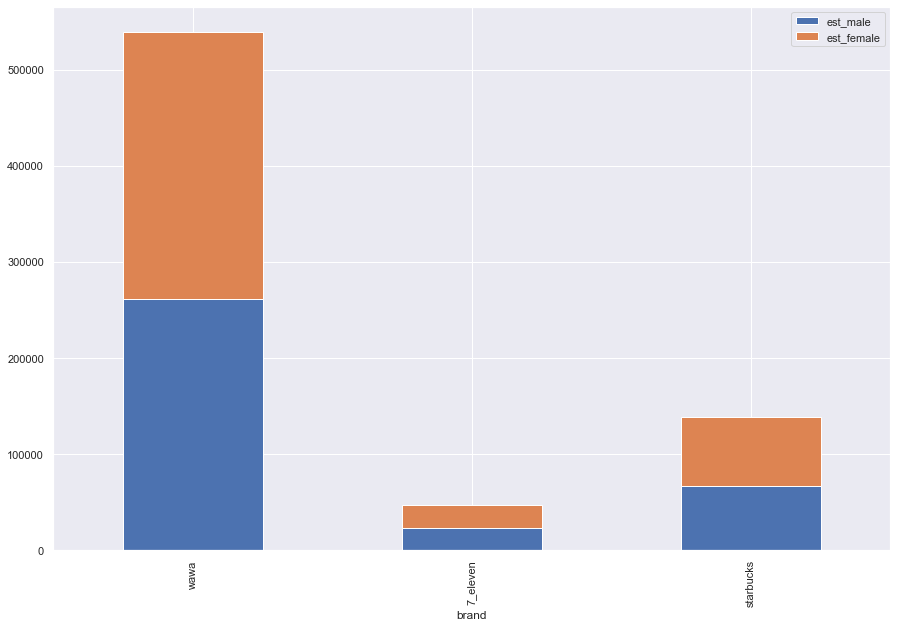

In [25]:
data = calc_gender(['wawa', '7_eleven', 'starbucks'])
display(data)

data.plot(kind='bar', x='brand', stacked=True)

In [311]:
def calc_race(brands):
    cbg_visits = pd.read_csv(f"{data_path}/processed/cbg_visits.csv", dtype={'census_block_group': "object"})
    
    data = read_census_data({
        "B01001e1": "total_population",
        "B02001e2": "pop_white",
        "B02001e3": "pop_black",
        "B02001e5": "pop_asian"
    })
    
    dfs = []
    
    for brand in brands:
        
        df = cbg_visits.set_index("census_block_group")[f"visits_{brand}"].to_frame().merge(data, on='census_block_group', how='left').fillna(0)
        df = df[df['total_population'] > 0]
    
   
        df['percent_black'] = df.apply(lambda x: x.pop_black / x.total_population, axis=1)
        df['percent_white'] = df.apply(lambda x: x.pop_white / x.total_population, axis=1)
        df['percent_asian'] = df.apply(lambda x: x.pop_asian / x.total_population, axis=1)
        df['percent_other'] = df.apply(lambda x: 1 - (x.percent_black + x.percent_white + x.percent_asian), axis=1)

        df['est_black'] = df[f'visits_{brand}'] * df['percent_black']
        df['est_white'] = df[f'visits_{brand}'] * df['percent_white']
        df['est_asian'] = df[f'visits_{brand}'] * df['percent_asian']
        df['est_other'] = df[f'visits_{brand}'] * df['percent_other']
    
        df = df[['est_white', 'est_black', 'est_asian', 'est_other']].sum().to_frame().T
        df['brand'] = brand
        dfs.append(df)
    
    return pd.concat(dfs)[['brand', 'est_white', 'est_black', 'est_asian', 'est_other']]

calc_race(['wawa', '7_eleven'])

Data Sets:  ['b01', 'b02']


,brand,est_white,est_black,est_asian,est_other
0,wawa,411909.998012,73329.153946,25851.606813,27588.241229
0,7_eleven,33472.483575,8303.688045,2554.616549,2840.211831


Data Sets:  ['b01', 'b02']


,brand,est_white,est_black,est_asian,est_other
0,wawa,411909.998012,73329.153946,25851.606813,27588.241229
0,7_eleven,33472.483575,8303.688045,2554.616549,2840.211831


<AxesSubplot:xlabel='brand'>

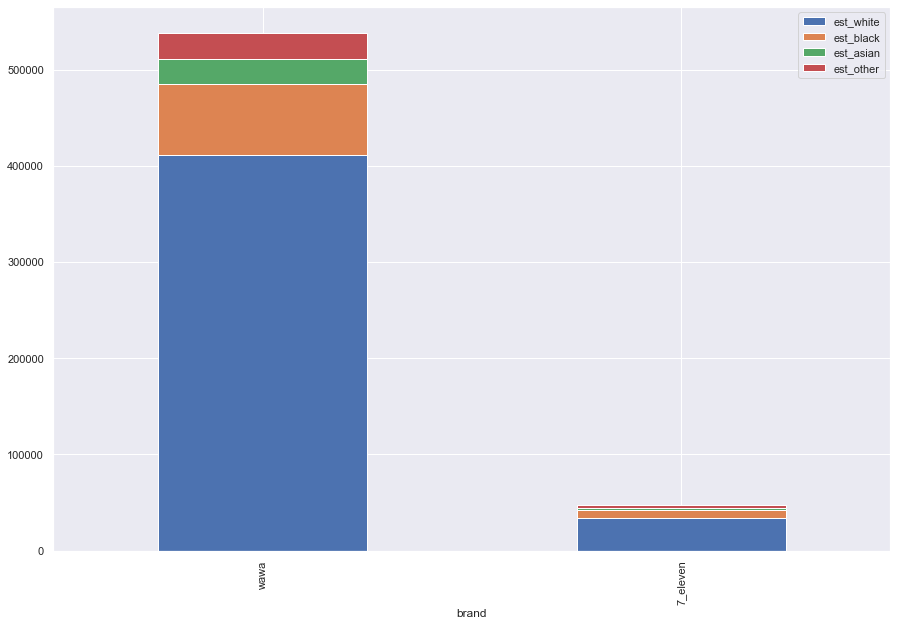

In [379]:
data = calc_race(['wawa', '7_eleven'])
display(data)
data.plot(kind='bar', x='brand', stacked=True)

In [49]:
def calc_age(brands):
    cbg_visits = pd.read_csv(f"{data_path}/processed/cbg_visits.csv", dtype={'census_block_group': "object"})
    
    age_dict = {
        "total_population": ["B01001e1"],
        "total_population_male": ["B01001e2"],
        "total_population_female": ["B01001e26"],
        "male_20_29": ["B01001e8", "B01001e9", "B01001e10","B01001e11"],
        "male_30_39": ["B01001e12","B01001e13"],
        "male_40_49": ["B01001e14", "B01001e15"],
        "male_50_59": ["B01001e16","B01001e17"],
        "male_60_69": ["B01001e18", "B01001e19", "B01001e20", "B01001e21"],
        "male_70+": ["B01001e22", "B01001e23", "B01001e24", "B01001e25"],
        'female_20_29': ["B01001e32", "B01001e33", "B01001e34","B01001e35"],
        'female_30_39': ["B01001e36", "B01001e37"],
        'female_40_49': ["B01001e38", "B01001e39"],
        'female_50_59': ["B01001e40", "B01001e41"],
        'female_60_69': ["B01001e42", "B01001e43","B01001e44", "B01001e45"],
        'female_70+': ["B01001e46", "B01001e47", "B01001e48", "B01001e49"]
    }
    
    data = read_census_data2(age_dict)
    
    dfs=[]
    
    for brand in brands:
        
        df = cbg_visits.set_index("census_block_group")[f"visits_{brand}"].to_frame().merge(data, on='census_block_group', how='left').fillna(0)
        df = df[df['total_population'] > 0]
        
        
        df['sum_20_29'] = df[['male_20_29', 'female_20_29']].sum(axis=1)
        df['sum_30_39'] = df[['male_30_39', 'female_30_39']].sum(axis=1)
        df['sum_40_49'] = df[['male_40_49', 'female_40_49']].sum(axis=1)
        df['sum_50_59'] = df[['male_50_59', 'female_50_59']].sum(axis=1)
        df['sum_60_69'] = df[['male_60_69', 'female_60_69']].sum(axis=1)
        df['sum_70+'] = df[['male_70+', 'female_70+']].sum(axis=1)
        
        df['percent_20_29'] = df.apply(lambda x: x.sum_20_29 / x.total_population, axis=1)
        df['percent_30_39'] = df.apply(lambda x: x.sum_30_39 / x.total_population, axis=1)
        df['percent_40_49'] = df.apply(lambda x: x.sum_40_49 / x.total_population, axis=1)
        df['percent_50_59'] = df.apply(lambda x: x.sum_50_59 / x.total_population, axis=1)
        df['percent_60_69'] = df.apply(lambda x: x.sum_60_69 / x.total_population, axis=1)
        df['percent_70+'] = df.apply(lambda x: x['sum_70+'] / x.total_population, axis=1)
        
        df['est_20_29'] = df[f'visits_{brand}'] * df['percent_20_29']
        df['est_30_39'] = df[f'visits_{brand}'] * df['percent_30_39']
        df['est_40_49'] = df[f'visits_{brand}'] * df['percent_40_49']
        df['est_50_59'] = df[f'visits_{brand}'] * df['percent_50_59']
        df['est_60_69'] = df[f'visits_{brand}'] * df['percent_60_69']
        df['est_70+'] = df[f'visits_{brand}'] * df['percent_70+']
        
        df = df[['est_20_29', 'est_30_39', 'est_40_49', 'est_50_59', 'est_60_69', 'est_70+']].sum().to_frame().T
        df['brand'] = brand
        dfs.append(df)
    
    return pd.concat(dfs)[['brand', 'est_20_29', 'est_30_39', 'est_40_49', 'est_50_59', 'est_60_69', 'est_70+']]

calc_age(['wawa', '7_eleven'])

Data Sets:  ['b01']


,brand,est_20_29,est_30_39,est_40_49,est_50_59,est_60_69,est_70+
0,wawa,68468.779705,65535.192310,74365.337112,81957.404680,60069.451254,54190.341860
0,7_eleven,6583.374002,6080.792868,6235.021845,6961.634045,5062.954370,4669.890474


Data Sets:  ['b01']


,brand,est_20_29,est_30_39,est_40_49,est_50_59,est_60_69,est_70+
0,wawa,68468.779705,65535.192310,74365.337112,81957.404680,60069.451254,54190.341860
0,7_eleven,6583.374002,6080.792868,6235.021845,6961.634045,5062.954370,4669.890474
0,starbucks,17983.756690,16207.803680,18918.450707,21093.618466,15453.463777,14155.582149


<AxesSubplot:xlabel='brand'>

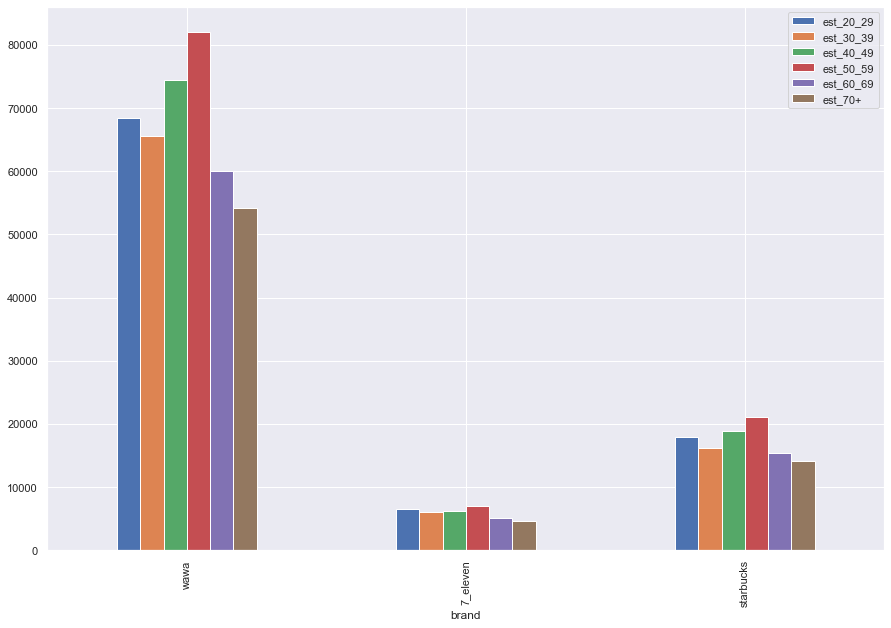

In [140]:
data = calc_age(['wawa', '7_eleven', 'starbucks'])
display(data)
data.plot(kind='bar', x='brand')

In [78]:
def calc_median_age(brands):
    cbg_visits = pd.read_csv(f"{data_path}/processed/cbg_visits.csv", dtype={'census_block_group': "object"})
    
    data = read_census_data({
        "B01002e2": "male_median_age",
        "B01002e3": "female_median_age"
    })
    
    dfs = []
    
    for brand in brands:
        df = cbg_visits.set_index("census_block_group")[f"visits_{brand}"].to_frame().merge(data, on='census_block_group', how='left').fillna(0)
        df = df[df[f"visits_{brand}"] > 0]
        
        df = df[['male_median_age','female_median_age']].median().to_frame().T
        df['brand'] = brand
        dfs.append(df)
        
    
    return pd.concat(dfs)[['brand', 'male_median_age', 
                           'female_median_age']]

calc_median_age(['wawa', 'starbucks', '7_eleven'])

Data Sets:  ['b01']


,brand,male_median_age,female_median_age
0,wawa,38.8,41.4
0,starbucks,38.9,41.2
0,7_eleven,38.0,40.8


In [113]:
# median_age = calc_median_age(['wawa', 'starbucks', '7_eleven'])
l = [row.to_dict() for i,row in median_age.iterrows()]
display(median_age)
for i in l:
    print(f"brand: {i['brand']}    median_age: {i['male_median_age']}")

,brand,male_median_age,female_median_age
0,wawa,38.8,41.4
0,starbucks,38.9,41.2
0,7_eleven,38.0,40.8


brand: wawa    median_age: 38.8
brand: starbucks    median_age: 38.9
brand: 7_eleven    median_age: 38.0


In [128]:
# median_ages = [row.to_dict() for i,row in calc_median_age(['wawa', 'starbucks']).iterrows()]
median_ages

[{'brand': 'wawa', 'male_median_age': 38.8, 'female_median_age': 41.4},
 {'brand': 'starbucks', 'male_median_age': 38.9, 'female_median_age': 41.2}]

In [155]:
# d = calc_age(['wawa']).iloc[0].to_dict()
list(d.keys())[1:]
list(d.values())[1:]

[68468.77970507281,
 65535.19230974805,
 74365.33711221132,
 81957.40467973084,
 60069.451254208405,
 54190.34186028796]